# Airdrops -- Exploratory Data Analysis

**[Johnnatan Messias](https://johnnatan-messias.github.io/), March 2025**.


In [1]:
import gzip
import pickle
import json
import os
from tqdm.notebook import tqdm
import polars as pl

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
import plotly.graph_objects as go
from plot_utils import get_plotly_layout, colors, percentiles, ECDF
import networkx as nx

In [4]:
protocols = ["ens", "dydx", "1inch",
             "gemstone", "arbitrum", "uniswap", "arkham", "lido", "tornado"]

In [5]:
plot_settings = {
    "ens": {'color': colors['blue'], 'label': 'ENS', 'style': 'solid', 'width': 4.5},
    "dydx": {'color': colors['red'], 'label': 'DYDX', 'style': 'dash', 'width': 4},
    "1inch": {'color': colors['green'], 'label': '1inch', 'style': 'dot', 'width': 3.5},
    "gemstone": {'color': colors['grey'], 'label': 'Gemstone', 'style': 'dashdot', 'width': 3},
    "arbitrum": {'color': colors['pink'], 'label': 'Arbitrum', 'style': 'solid', 'width': 2.5},
    "uniswap": {'color': colors['brown'], 'label': 'Uniswap', 'style': 'dash', 'width': 2},
    "arkham": {'color': colors['gold'], 'label': 'Arkham', 'style': 'dot', 'width': 1.5},
    "lido": {'color': colors['black'], 'label': 'Lido', 'style': 'dashdot', 'width': 1},
    "tornado": {'color': colors['pink'], 'label': 'TornadoCash', 'style': 'solid', 'width': 1},
}

In [6]:
data_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "data"))

plots_dir = os.path.realpath(os.path.join(data_dir, "..", "plots"))

os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [7]:
from labels import Labels
labels = Labels()
dead_addresses = labels.get_dead_addresses()

In [8]:
decimals = 1e18

# Loading data


In [9]:
def load_dataset(protocols):
    dfs = {}
    for protocol in tqdm(protocols):
        file_transfer_dir = os.path.realpath(os.path.join(
            data_dir, "{}_transfer.parquet".format(protocol)))
        file_claim_dir = os.path.realpath(os.path.join(
            data_dir, "{}_claim.parquet".format(protocol)))
        dfs[protocol] = {'transfer': pl.scan_parquet(file_transfer_dir),
                         'claim': pl.scan_parquet(file_claim_dir)}
    return dfs

In [10]:
dfs = load_dataset(protocols)
for protocol in protocols:
    print(protocol)
    dfs[protocol]['transfer'] = dfs[protocol]['transfer'].rename(
        {'from': 'sender', 'to': 'receiver'})
    if protocol in ["dydx", "1inch", "uniswap", "lido", "tornado"]:
        dfs[protocol]['claim'] = dfs[protocol]['claim'].rename(
            {'to': 'receiver'})
    else:
        dfs[protocol]['claim'] = dfs[protocol]['claim'].rename(
            {'account': 'receiver'})

  0%|          | 0/9 [00:00<?, ?it/s]

ens
dydx
1inch
gemstone
arbitrum
uniswap
arkham
lido
tornado


In [11]:
# for protocol in tqdm(dfs):
#     dfs[protocol]['transfer'].rename(columns=columns_claim, inplace=True)
#     dfs[protocol]['claim'].rename(columns=columns_claim, inplace=True)
#     dfs[protocol]['transfer']['timestamp'] = pd.to_datetime(
#         dfs[protocol]['transfer']['timestamp'])
#     dfs[protocol]['claim']['timestamp'] = pd.to_datetime(
#         dfs[protocol]['claim']['timestamp'])
#     dfs[protocol]['claim']['timestamp'] = dfs[protocol]['claim']['timestamp'].dt.tz_localize(
#         None)
#     if protocol != 'arbitrum':
#         dfs[protocol]['claim']['amount'] = dfs[protocol]['claim']['amount'].astype(
#             float)/decimals
#         dfs[protocol]['transfer']['amount'] = dfs[protocol]['transfer']['amount'].astype(
#             float)/decimals
#     # dfs[protocol]['claim'] = dfs[protocol]['claim'].query("timestamp < '2024-01-01'")
#     dfs[protocol]['transfer'] = dfs[protocol]['transfer'].query(
#         "timestamp < '2024-01-01'")

In [12]:
for protocol in dfs:
    print(protocol)
    type = "claim"
    print("\t", type, dfs[protocol][type].select('timestamp').min().collect().item(),
          "\t", dfs[protocol][type].select('timestamp').max().collect().item())
    type = "transfer"
    print("\t", type, dfs[protocol][type].select('timestamp').min().collect().item(),
          "\t", dfs[protocol][type].select('timestamp').max().collect().item())

ens
	 claim 2021-11-09 00:01:26 	 2024-08-04 04:28:23
	 transfer 2021-11-01 20:55:17 	 2024-10-19 13:35:47
dydx
	 claim 2021-09-08 05:24:48 	 2024-10-18 18:32:35
	 transfer 2021-07-12 01:37:12 	 2024-10-19 13:45:47
1inch
	 claim 2020-12-25 00:08:54 	 2024-10-18 21:35:47
	 transfer 2020-12-23 18:13:31 	 2024-10-19 13:45:47
gemstone
	 claim 2023-07-23 21:50:55 	 2023-09-11 08:47:07
	 transfer 2023-07-18 07:43:39 	 2023-09-11 08:47:17
arbitrum
	 claim 2023-03-23 13:01:22+00:00 	 2023-09-24 20:12:52+00:00
	 transfer 2023-03-16 12:08:28+00:00 	 2024-05-14 23:59:58+00:00
uniswap
	 claim 2020-09-16 21:32:52 	 2024-10-19 13:33:11
	 transfer 2020-09-14 18:11:26 	 2024-10-19 13:44:23
arkham
	 claim 2023-07-18 07:41:35 	 2024-09-13 10:37:11
	 transfer 2023-07-05 15:44:59 	 2024-10-19 13:15:11
lido
	 claim 2021-01-05 18:16:51 	 2024-09-15 01:53:23
	 transfer 2020-12-17 22:12:05 	 2024-10-19 13:44:47
tornado
	 claim 2020-12-18 03:52:06 	 2022-08-11 18:16:02
	 transfer 2020-12-18 03:00:37 	 2024-10-

In [13]:
for protocol in dfs:
    print(protocol)
    type = "claim"
    print("\t", type, dfs[protocol][type].select('blockNumber').min().collect().item(),
          "\t", dfs[protocol][type].select('blockNumber').max().collect().item())
    type = "transfer"
    print("\t", type, dfs[protocol][type].select('blockNumber').min().collect().item(),
          "\t", dfs[protocol][type].select('blockNumber').max().collect().item())

ens
	 claim 13578843 	 20452797
	 transfer 13533418 	 20999950
dydx
	 claim 13183164 	 20994261
	 transfer 12809555 	 21000000
1inch
	 claim 11519481 	 20995174
	 transfer 11511393 	 21000000
gemstone
	 claim 9375492 	 13566160
	 transfer 8898950 	 13566160
arbitrum
	 claim 72829612 	 134244706
	 transfer 70398215 	 211336634
uniswap
	 claim 10875578 	 20999937
	 transfer 10861674 	 20999993
arkham
	 claim 17718694 	 20741142
	 transfer 17628655 	 20999848
lido
	 claim 11596109 	 20752853
	 transfer 11473276 	 20999995
tornado
	 claim 11474827 	 15322201
	 transfer 11474599 	 20999592


In [14]:
for protocol in dfs:
    print('There are {} Transfer and {} claiming events for {}'.format(
        dfs[protocol]['transfer'].select(pl.len()).collect().item(),
        dfs[protocol]['claim'].select(pl.len()).collect().item(), protocol))

There are 998619 Transfer and 102824 claiming events for ens
There are 747372 Transfer and 88757 claiming events for dydx
There are 1782998 Transfer and 43806 claiming events for 1inch
There are 261896 Transfer and 21778 claiming events for gemstone
There are 47330340 Transfer and 583137 claiming events for arbitrum
There are 4872925 Transfer and 221087 claiming events for uniswap
There are 283775 Transfer and 64724 claiming events for arkham
There are 1107586 Transfer and 516 claiming events for lido
There are 278455 Transfer and 5474 claiming events for tornado


In [15]:
dfs['dydx']['claim'].head().collect()

shape: (5, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ blockNumb ┆ transacti ┆ blockHash ┆ address   ┆ … ┆ from      ┆ receiver  ┆ amount    ┆ timestam │
│ er        ┆ onHash    ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ p        │
│ ---       ┆ ---       ┆ str       ┆ str       ┆   ┆ str       ┆ str       ┆ f64       ┆ ---      │
│ i64       ┆ str       ┆           ┆           ┆   ┆           ┆           ┆           ┆ datetime │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ [ns]     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 13183164  ┆ 361400ec6 ┆ 66eebcd18 ┆ 0x92d6c1e ┆ … ┆ 0x639192d ┆ 0x54af6a1 ┆ 0.158492  ┆ 2021-09- │
│           ┆ 79147ed45 ┆ b681919af ┆ 31e14520e ┆   ┆ 54431f8c8 ┆ dbacfa9dd ┆           ┆ 08       │
│           ┆ 75ac2215d ┆ fcf267100 ┆ 676a687f0 ┆   ┆ 16368d3fb ┆ dd72a7dd1 ┆           ┆ 05:24:48 │
│           ┆ e48…      ┆ 740…      ┆ a93…      ┆   ┆ 410…      ┆ b4f…      ┆           ┆          │
│ 13185646  ┆ 53629569b ┆ c9adf2ffc ┆ 0x92d6c1e ┆ … ┆ 0x639192d ┆ 0x75dc9a1 ┆ 0.0       ┆ 2021-09- │
│           ┆ eb5d8dd59 ┆ 238e0fe42 ┆ 31e14520e ┆   ┆ 54431f8c8 ┆ 2bf025651 ┆           ┆ 08       │
│           ┆ 0edc169ea ┆ ad28cad4f ┆ 676a687f0 ┆   ┆ 16368d3fb ┆ 36ddf3e27 ┆           ┆ 14:23:45 │
│           ┆ 093…      ┆ b74…      ┆ a93…      ┆   ┆ 410…      ┆ fcb…      ┆           ┆          │
│ 13185813  ┆ 751c7b32b ┆ bab2daf70 ┆ 0x92d6c1e ┆ … ┆ 0x639192d ┆ 0x8568e1a ┆ 1178.2097 ┆ 2021-09- │
│           ┆ a3ed77f59 ┆ 04c944c53 ┆ 31e14520e ┆   ┆ 54431f8c8 ┆ 8082b442a ┆ 7         ┆ 08       │
│           ┆ dc2776a91 ┆ 110396282 ┆ 676a687f0 ┆   ┆ 16368d3fb ┆ e9be089a3 ┆           ┆ 15:00:53 │
│           ┆ 0dc…      ┆ 08f…      ┆ a93…      ┆   ┆ 410…      ┆ b38…      ┆           ┆          │
│ 13185813  ┆ f1664ae2d ┆ bab2daf70 ┆ 0x92d6c1e ┆ … ┆ 0x639192d ┆ 0x44acd0f ┆ 4350.8103 ┆ 2021-09- │
│           ┆ a908ee8a7 ┆ 04c944c53 ┆ 31e14520e ┆   ┆ 54431f8c8 ┆ f3be9fdfb ┆ 46        ┆ 08       │
│           ┆ 1e88afe86 ┆ 110396282 ┆ 676a687f0 ┆   ┆ 16368d3fb ┆ 932453c82 ┆           ┆ 15:00:53 │
│           ┆ d25…      ┆ 08f…      ┆ a93…      ┆   ┆ 410…      ┆ b5d…      ┆           ┆          │
│ 13185813  ┆ 0f6a0ed8d ┆ bab2daf70 ┆ 0x92d6c1e ┆ … ┆ 0x639192d ┆ 0xf7e39bf ┆ 1163.6464 ┆ 2021-09- │
│           ┆ 5e6854709 ┆ 04c944c53 ┆ 31e14520e ┆   ┆ 54431f8c8 ┆ a90e8501f ┆ 14        ┆ 08       │
│           ┆ e12d57bb6 ┆ 110396282 ┆ 676a687f0 ┆   ┆ 16368d3fb ┆ e2f2a1333 ┆           ┆ 15:00:53 │
│           ┆ 5b6…      ┆ 08f…      ┆ a93…      ┆   ┆ 410…      ┆ e3e…      ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [16]:
for protocol in dfs:
    print('{}: There are {} accounts receiving the airdrop'.format(
        protocol,
        dfs[protocol]['claim'].select(pl.n_unique('receiver')).collect().item()))

ens: There are 102824 accounts receiving the airdrop
dydx: There are 47472 accounts receiving the airdrop
1inch: There are 43806 accounts receiving the airdrop
gemstone: There are 20014 accounts receiving the airdrop
arbitrum: There are 583137 accounts receiving the airdrop
uniswap: There are 221087 accounts receiving the airdrop
arkham: There are 64719 accounts receiving the airdrop
lido: There are 507 accounts receiving the airdrop
tornado: There are 5347 accounts receiving the airdrop


### EDA


In [17]:
dfs[protocol]['claim'].select(['timestamp', 'amount']).collect()

shape: (5_474, 2)
┌─────────────────────┬───────────────┐
│ timestamp           ┆ amount        │
│ ---                 ┆ ---           │
│ datetime[ns]        ┆ f64           │
╞═════════════════════╪═══════════════╡
│ 2020-12-18 03:52:06 ┆ 162.61859     │
│ 2020-12-18 06:13:48 ┆ 25.439346     │
│ 2020-12-18 06:49:55 ┆ 20.2191       │
│ 2020-12-18 07:05:44 ┆ 15.270503     │
│ 2020-12-18 07:15:51 ┆ 24.086706     │
│ …                   ┆ …             │
│ 2021-12-11 09:01:22 ┆ 57.003199     │
│ 2021-12-12 10:38:50 ┆ 59.432344     │
│ 2021-12-17 15:02:34 ┆ 143831.157593 │
│ 2022-03-20 17:55:03 ┆ 0.0           │
│ 2022-08-11 18:16:02 ┆ 0.0           │
└─────────────────────┴───────────────┘

The total amount of tokens claimed for ens was 19632454.199476592.


shape: (1, 17)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count    ┆ null_coun ┆ mean      ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max       │
│ ---      ┆ t         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64      ┆ ---       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
│          ┆ f64       ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 102824.0 ┆ 0.0       ┆ 190.93260 ┆ 141.56543 ┆ … ┆ 389.08010 ┆ 443.79668 ┆ 696.28294 ┆ 1143.5442 │
│          ┆           ┆ 5         ┆ 8         ┆   ┆ 1         ┆ 2         ┆ 1         ┆ 04        │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

The total amount of tokens claimed for dydx was 243590661.09338498.


shape: (1, 17)
┌─────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ count   ┆ null_count ┆ mean       ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max      │
│ ---     ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64     ┆ f64        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 88757.0 ┆ 0.0        ┆ 2744.46704 ┆ 160803.59 ┆ … ┆ 3798.2585 ┆ 5161.0472 ┆ 17818.702 ┆ 4.0704e7 │
│         ┆            ┆            ┆ 4202      ┆   ┆ 76        ┆ 19        ┆ 928       ┆          │
└─────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

The total amount of tokens claimed for 1inch was 83642822.40415813.


shape: (1, 17)
┌─────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ count   ┆ null_count ┆ mean       ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max      │
│ ---     ┆ ---        ┆ ---        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64     ┆ f64        ┆ f64        ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 43806.0 ┆ 0.0        ┆ 1909.39191 ┆ 49932.960 ┆ … ┆ 1368.0345 ┆ 2486.0056 ┆ 12637.146 ┆ 9.7497e6 │
│         ┆            ┆ 9          ┆ 031       ┆   ┆ 94        ┆ 41        ┆ 876       ┆          │
└─────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

The total amount of tokens claimed for gemstone was 5.0394775e+16.


shape: (1, 17)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count   ┆ null_count ┆ mean      ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max       │
│ ---     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64     ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 21778.0 ┆ 0.0        ┆ 2.3140e12 ┆ 6.9318e11 ┆ … ┆ 2.6140e12 ┆ 2.6270e12 ┆ 2.6370e12 ┆ 2.6390e12 │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

The total amount of tokens claimed for arbitrum was 1092811500.0.


shape: (1, 17)
┌──────────┬────────────┬─────────────┬─────────────┬───┬────────┬────────┬────────┬─────────┐
│ count    ┆ null_count ┆ mean        ┆ std         ┆ … ┆ 90%    ┆ 95%    ┆ 99%    ┆ max     │
│ ---      ┆ ---        ┆ ---         ┆ ---         ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---     │
│ f64      ┆ f64        ┆ f64         ┆ f64         ┆   ┆ f64    ┆ f64    ┆ f64    ┆ f64     │
╞══════════╪════════════╪═════════════╪═════════════╪═══╪════════╪════════╪════════╪═════════╡
│ 583137.0 ┆ 0.0        ┆ 1874.021885 ┆ 1566.916169 ┆ … ┆ 3750.0 ┆ 5250.0 ┆ 8500.0 ┆ 10250.0 │
└──────────┴────────────┴─────────────┴─────────────┴───┴────────┴────────┴────────┴─────────┘

The total amount of tokens claimed for uniswap was 137040499.27698204.


shape: (1, 17)
┌──────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ count    ┆ null_count ┆ mean      ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max      │
│ ---      ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64      ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞══════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 221087.0 ┆ 0.0        ┆ 619.84874 ┆ 9330.2677 ┆ … ┆ 402.27406 ┆ 422.07563 ┆ 1392.0453 ┆ 2.1035e6 │
│          ┆            ┆ 4         ┆ 53        ┆   ┆ 4         ┆ 3         ┆ 26        ┆          │
└──────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

The total amount of tokens claimed for arkham was 29394517.342645075.


shape: (1, 17)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count   ┆ null_count ┆ mean      ┆ std       ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max       │
│ ---     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64     ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 64724.0 ┆ 0.0        ┆ 454.15174 ┆ 2348.9428 ┆ … ┆ 789.71782 ┆ 1776.8650 ┆ 3553.7301 ┆ 249353.40 │
│         ┆            ┆ 2         ┆ 85        ┆   ┆ 1         ┆ 98        ┆ 96        ┆ 2081      │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

The total amount of tokens claimed for lido was 3971044.797424059.


shape: (1, 17)
┌───────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count ┆ null_count ┆ mean       ┆ std        ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max       │
│ ---   ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64   ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 516.0 ┆ 0.0        ┆ 7695.82325 ┆ 53597.3998 ┆ … ┆ 4397.4874 ┆ 12710.838 ┆ 131296.73 ┆ 746286.49 │
│       ┆            ┆ 1          ┆ 35         ┆   ┆ 48        ┆ 713       ┆ 2681      ┆ 0915      │
└───────┴────────────┴────────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

The total amount of tokens claimed for tornado was 500000.00000000006.


shape: (1, 17)
┌────────┬────────────┬───────────┬────────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ count  ┆ null_count ┆ mean      ┆ std        ┆ … ┆ 90%       ┆ 95%       ┆ 99%       ┆ max       │
│ ---    ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64    ┆ f64        ┆ f64       ┆ f64        ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════╪════════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 5474.0 ┆ 0.0        ┆ 91.340884 ┆ 1948.05229 ┆ … ┆ 147.53123 ┆ 270.50986 ┆ 697.33719 ┆ 143831.15 │
│        ┆            ┆           ┆ 9          ┆   ┆           ┆ 3         ┆ 3         ┆ 7593      │
└────────┴────────────┴───────────┴────────────┴───┴───────────┴───────────┴───────────┴───────────┘

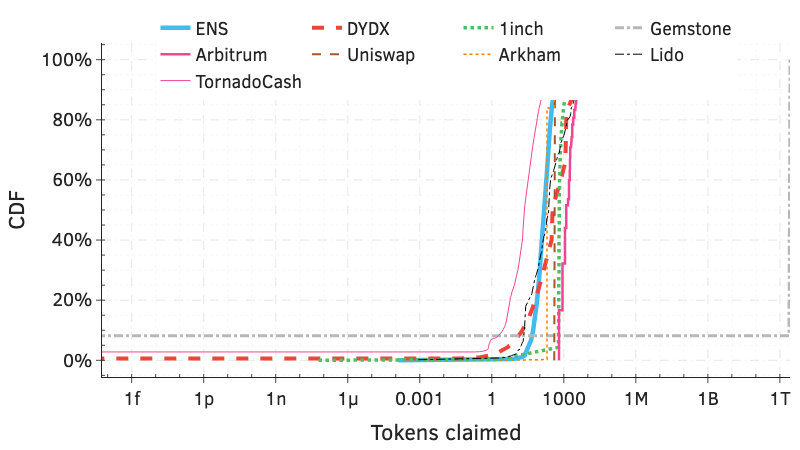

In [18]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    data = dfs[protocol]['claim'].select(['timestamp', 'amount']).collect()
    print("The total amount of tokens claimed for {} was {}.".format(
        protocol, data['amount'].sum()))
    display(data['amount'].describe(
        percentiles=percentiles).transpose(column_names="statistic"))
    ecdf = ECDF(data['amount'])
    fig.add_trace(go.Scatter(x=ecdf.x, y=ecdf.y, name=plot_settings[protocol]['label'],
                             line=dict(color=plot_settings[protocol]['color'], width=plot_settings[protocol]['width'], dash=plot_settings[protocol]['style'])))

fig.update_layout(
    xaxis_title='Tokens claimed',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.1, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
fig.show('png')

In [19]:
# Analysis of the top earners
for protocol in protocols:
    top_earner = dfs[protocol]['claim'].select(
        pl.max('amount')).collect().item()
    print("The top earner for {} earned {} tokens that represents {}% of all tokens distributed.".format(
        protocol, top_earner, round(100*top_earner/dfs[protocol]['claim'].select(pl.sum('amount')).collect().item(), 2)))

The top earner for ens earned 1143.5442044346885 tokens that represents 0.01% of all tokens distributed.
The top earner for dydx earned 40703630.60980841 tokens that represents 16.71% of all tokens distributed.
The top earner for 1inch earned 9749686.003287062 tokens that represents 11.66% of all tokens distributed.
The top earner for gemstone earned 2639000000000.0 tokens that represents 0.01% of all tokens distributed.
The top earner for arbitrum earned 10250.0 tokens that represents 0.0% of all tokens distributed.
The top earner for uniswap earned 2103516.5902480003 tokens that represents 1.53% of all tokens distributed.
The top earner for arkham earned 249353.4020813408 tokens that represents 0.85% of all tokens distributed.
The top earner for lido earned 746286.4909149566 tokens that represents 18.79% of all tokens distributed.
The top earner for tornado earned 143831.1575925667 tokens that represents 28.77% of all tokens distributed.


## Airdrop list

Lido list (https://docs.lido.fi/guides/1inch-pool-rewards):

- https://github.com/lidofinance/airdrop-data/blob/main/early_stakers_airdrop.csv
- https://github.com/lidofinance/airdrop-data/blob/main/oneinch_lido_airdrop.csv

Tornado list: https://github.com/tornadocash/airdrop/blob/master/airdrop.csv


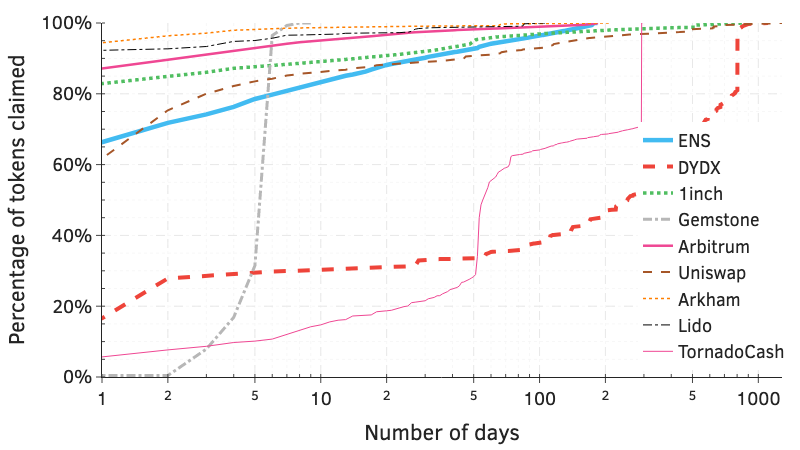

In [20]:
# Plot of the amount of tokens claimed
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))

for protocol in protocols:
    data = (dfs[protocol]['claim']
            .with_columns(pl.col('timestamp').cast(pl.Date).alias('date'))
            .group_by('date')
            .agg(pl.sum('amount'))
            .sort('date')
            .with_columns(pl.cum_sum('amount').truediv(pl.sum('amount')))
            .with_row_index()
            ).collect()

    # display((data['amount']).describe(percentiles=percentiles).to_frame().T)
    # print("Total amount claimed: {} {}".format(data['amount'].sum(), protocol))

    fig.add_trace(go.Scatter(x=data['index'], y=data['amount'],
                             line=dict(
                                 color=plot_settings[protocol]['color'],
                                 width=plot_settings[protocol]['width'],
                                 dash=plot_settings[protocol]['style']),
                             mode='lines', name=plot_settings[protocol]['label']))
fig.update_layout(
    xaxis_title='Number of days',
    yaxis_title='Percentage of tokens claimed',
    legend=dict(xanchor='center', x=0.9, y=0.02, orientation='v'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%", range=[0, 1])

fig.write_image(
    plots_dir + 'tokens_claimed_per_day.pdf')
fig.show("png")

## The code and analysis below will be updated ...

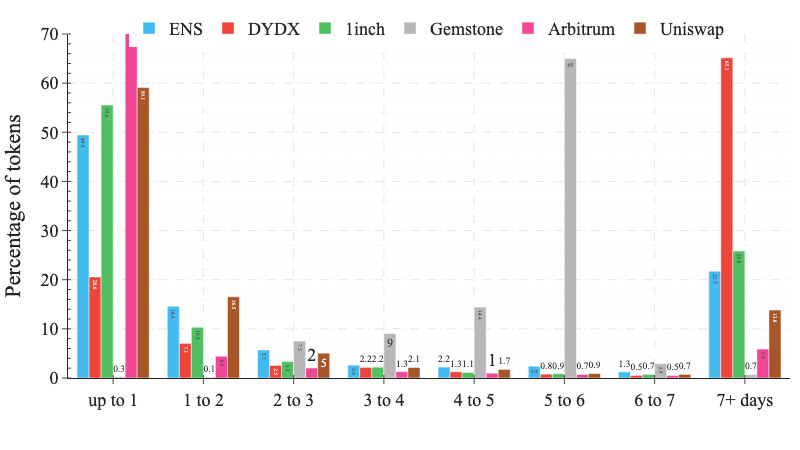

In [25]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
text = ['up to 1', '1 to 2', '2 to 3',
        '3 to 4', '4 to 5', '5 to 6', '6 to 7', '7+ days']

for protocol in protocols:
    data_df = dfs[protocol]['claim'][[
        'timestamp', 'amount']].reset_index(drop=True)
    data_df['claim_delay_hour'] = (
        data_df['timestamp'] - data_df['timestamp'].min()).dt.total_seconds()/3600

    bins = [0, 24, 48, 72, 96, 120, 144, 168,
            data_df['claim_delay_hour'].max()]

    data = (100 * pd.cut(data_df['claim_delay_hour'],
            bins=bins, right=True).value_counts(normalize=True)).sort_index()

    fig.add_trace(go.Bar(x=text, y=data.values,
                         marker_color=plot_settings[protocol]['color'], textposition='auto', text=data.values.round(1), name=plot_settings[protocol]['label']))

fig.update_layout(yaxis_title="Percentage of tokens", xaxis_title="",

                  legend=dict(xanchor='center', x=0.5, y=1.07, orientation='h'))

fig.update_yaxes(range=[0, 70])


fig.write_image(plots_dir + 'claim_delay.pdf')
fig.show('png')

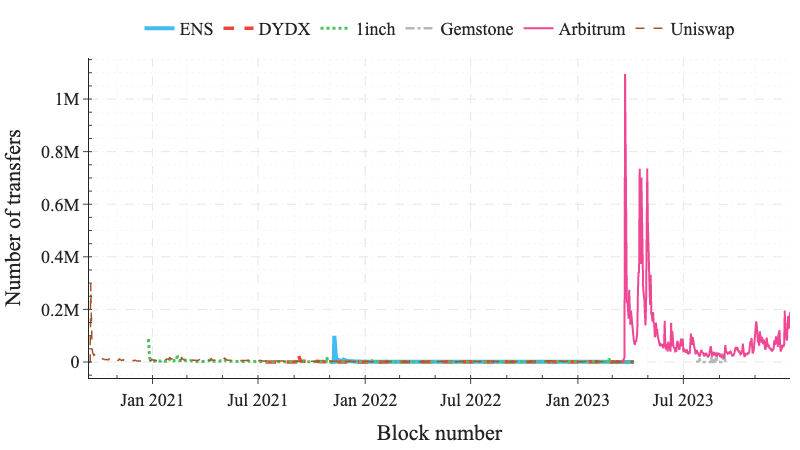

In [26]:
# Plot of the amount of ENS transferred over time
# data = ens_transfer_df[['timestamp', 'value']].set_index('timestamp')

fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    data = dfs[protocol]['transfer'][~dfs[protocol]['transfer']['sender'].isin(dead_addresses)][[
        'timestamp', 'amount']].set_index('timestamp')

    data = data.resample('1D').count()

    fig.add_trace(go.Scatter(x=data.index, y=data['amount'],
                             line=dict(
                                 color=plot_settings[protocol]['color'], width=plot_settings[protocol]['width'], dash=plot_settings[protocol]['style']),
                             mode='lines', name=plot_settings[protocol]['label']))

fig.update_layout(
    xaxis_title='Block number',
    yaxis_title='Number of transfers',
    legend=dict(xanchor='center', x=0.5, y=1.15, orientation='h'))

fig.show('png')

## Graph network analysis


In [27]:
addresses = dict()
exchanges = dict()
with open(data_dir+'addresses_dic.json') as f:
    addresses = json.load(f)
    ads = list(addresses.keys())
    for address in ads:
        addresses[address.lower()] = addresses.pop(address)

with open(data_dir+'addresses.json') as f:
    addresses.update(json.load(f))
    ads = list(addresses.keys())
    for address in ads:
        addresses[address.lower()] = addresses.pop(address)

with open(data_dir+'exchange_addresses.json') as f:
    data = json.load(f)
    for address in data.keys():
        exchanges[address.lower()] = data[address]

addresses.update(exchanges)
print("There are {} exchanges addresses".format(len(exchanges)))
print("There are {} addresses".format(len(addresses)))

There are 620 exchanges addresses
There are 98614 addresses


In [28]:
exchanges.update({
    '0x92560c178ce069cc014138ed3c2f5221ba71f58a': 'Uniswap V3',
    '0xa1181481beb2dc5de0daf2c85392d81c704bf75d': 'SushiSwap',
    '0xeb2629a2734e272bcc07bda959863f316f4bd4cf': 'Coinbase',

    '0x7aa1ed8fb5e820e38c86cf3dd0a9eb0169a149ad': 'Pool',  # Gemstone
    # '0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a': 'Pool',  # Gemstone
    '0xef523713706b93a31cfd083a2fe47847b714be55': '?',  # Gemstone
    '0x92fd143a8fa0c84e016c2765648b9733b0aa519e': 'Uniswap V3 - ARB/WETH',  # Arbitrum
    '0xa8328bf492ba1b77ad6381b3f7567d942b000baf': 'Uniswap - ARB/USDC',
    '0x64768a3a2453f1e8de9e43e92d65fc36e4c9872d': 'Uniswap ARB-WETH',
    '0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9': 'Uniswap - ARB/USDT'
})

addresses.update({
    '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72': 'ENS',
    '0x833af8617d03902efb4cc6f2eaa4d58ace6d3fc6': 'Gemstone',  # Gemstone
    # '0xef523713706b93a31cfd083a2fe47847b714be55': '?'  # Gemstone
    '0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a': '0 transfers'
})

In [29]:
airdrop_contracts = {
    '1inch': '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',  # 1inch
    'dydx': '0x639192d54431f8c816368d3fb4107bc168d0e871',  # DYDX
    'ens': '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',  # ENS
    'gemstone': '0xdea197d9920a7472050013ad7e8de0733da81d5c',  # Gemstone
    'arbitrum': '0x67a24ce4321ab3af51c2d0a4801c3e111d88c9d9',  # Arbitrum
    'uniswap': '0x090d4613473dee047c3f2706764f49e0821d256e',  # Uniswap
}

# dYdX 0x0fd829c3365a225fb9226e75c97c3a114bd3199e

In [30]:
exchanges['0xb9c4a5522a2f8ba9e2ff7063df8c02ed443337a3'] = 'Uniswap'
exchanges['0x92560c178ce069cc014138ed3c2f5221ba71f58a'] = 'Uniswap'
exchanges['0xa1181481beb2dc5de0daf2c85392d81c704bf75d'] = 'Sushiswap'
exchanges['0x5f7e8408e573e934b0df49ba5b569c30f1ebbad4'] = 'Uniswap'

exchanges['0x1df4139144595e0245b084e7ea1a75101fb95548'] = 'Uniswap V2: 1INCH-DAI'
exchanges['0x26aad2da94c59524ac0d93f6d6cbf9071d7086f2'] = 'Uniswap V2: 1INCH 10'

exchanges['0xe93381fb4c4f14bda253907b18fad305d799241a'] = 'Huobi'
exchanges['0xa0446d8804611944f1b527ecd37d7dcbe442caba'] = '1INCH Token (Staked)'
exchanges['0xd47140f6ab73f6d6b6675fb1610bb5e9b5d96fe5'] = '1inch router'


exchanges['0x6c4ab1907805adcb0b7ae911a5d1b0b99d608b3c'] = 'Uniswap V3: DYDX-USDT 2'
exchanges['0xad570798fa568d93c52ee0f9839278959b13a49b'] = 'Uniswap V3: DYDX-USDT'
exchanges['0xe0cfa17aa9b8f930fd936633c0252d5cb745c2c3'] = 'Uniswap V3: DYDX 3'
exchanges['0xd8de6af55f618a7bc69835d55ddc6582220c36c0'] = 'Uniswap V3: DYDX 2'
exchanges['0xe4ebd836832f1a8a81641111a5b081a2f90b9430'] = 'SushiSwap: DYDX'
exchanges['0x65f7ba4ec257af7c55fd5854e5f6356bbd0fb8ec'] = 'stkDYDX'

exchanges['0x7aa1ed8fb5e820e38c86cf3dd0a9eb0169a149ad'] = 'Gemstone'

In [31]:
data = dfs['gemstone']['transfer'][dfs['gemstone']['transfer']
                                   ['sender'] != '0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a']
data = data[data['receiver'] != '0x9687ec962a3a3f72e2c3b7604c31ccc7d1eec84a']
data.shape

(181859, 15)

In [32]:
Gs = dict()
for protocol in tqdm(protocols, desc='Generating graph network'):
    print(protocol)
    # .query('"2021-11-09" <= timestamp <= "2021-11-09 06:10:10"')
    data = dfs[protocol]['transfer'][~dfs[protocol]
                                     ['transfer']['sender'].isin(dead_addresses)]
    G = nx.MultiDiGraph(protocol=protocol)
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        if row['sender'] == airdrop_contracts[protocol]:
            continue
        G.add_edge(row['sender'], row['receiver'], amount=row['amount'], timestamp=str(
            row['timestamp']), block_number=row['block_number'])
    print("There are {} nodes and {} edges".format(G.number_of_nodes(),
                                                   G.number_of_edges()))
    Gs[protocol] = G

Generating graph network:   0%|          | 0/6 [00:00<?, ?it/s]

ens


  0%|          | 0/711285 [00:00<?, ?it/s]

There are 184585 nodes and 608462 edges
dydx


  0%|          | 0/482114 [00:00<?, ?it/s]

There are 112853 nodes and 406027 edges
1inch


  0%|          | 0/1444315 [00:00<?, ?it/s]

There are 308329 nodes and 1400913 edges
gemstone


  0%|          | 0/261891 [00:00<?, ?it/s]

There are 20003 nodes and 240113 edges
arbitrum


  0%|          | 0/28021746 [00:00<?, ?it/s]

There are 2025898 nodes and 27438608 edges
uniswap


  0%|          | 0/3982833 [00:00<?, ?it/s]

There are 1180830 nodes and 3762613 edges


In [33]:
def show_graph_info(graph):
    print("There are {} nodes and {} edges".format(
        graph.number_of_nodes(), graph.number_of_edges()))
    print("There are {} connected components".format(
        nx.number_connected_components(graph.to_undirected())))
    largest_component = sorted(nx.connected_components(
        graph.to_undirected()), key=len, reverse=True)[0]
    print("The largest component has {} nodes".format(len(largest_component)))


def cut_graph(graph, sources, cutoff=1):
    print("Graph {} and cutoff of {}".format(graph.graph['protocol'], cutoff))
    show_graph_info(graph)
    graph_dir = os.path.realpath(os.path.join(data_dir, "graphs")) + os.sep

    nodes_subgraph = list()
    for node_id in tqdm(sources, desc='Gathering reachable nodes'):
        if graph.has_node(node_id):
            nodes_subgraph += list(nx.single_source_shortest_path_length(
                graph, node_id, cutoff=cutoff))
    nodes_subgraph = set(nodes_subgraph)
    sub_graph = graph.subgraph(nodes_subgraph)
    show_graph_info(sub_graph)
    largest_component = sorted(nx.connected_components(
        sub_graph.to_undirected()), key=len, reverse=True)[0]
    biggest_subgraph = sub_graph.subgraph(largest_component)
    nx.write_gexf(
        sub_graph, graph_dir+"graph_{}_cutoff_{}.gexf".format(sub_graph.graph['protocol'], cutoff))
    nx.write_gexf(biggest_subgraph,
                  graph_dir+"graph_{}_cutoff_{}_biggest_component.gexf".format(biggest_subgraph.graph['protocol'], cutoff))
    return sub_graph

In [34]:
subgraphs = dict()
for protocol in tqdm(protocols):
    print(protocol)
    airdrop_claimers = dfs[protocol]['claim']['receiver'].unique()
    subgraphs[protocol] = cut_graph(
        graph=Gs[protocol], sources=airdrop_claimers, cutoff=1)
    print()

  0%|          | 0/6 [00:00<?, ?it/s]

ens
Graph ens and cutoff of 1
There are 184585 nodes and 608462 edges
There are 2203 connected components
The largest component has 179542 nodes


Gathering reachable nodes:   0%|          | 0/102822 [00:00<?, ?it/s]

There are 122072 nodes and 272330 edges
There are 18237 connected components
The largest component has 78639 nodes

dydx
Graph dydx and cutoff of 1
There are 112853 nodes and 406027 edges
There are 390 connected components
The largest component has 111788 nodes


Gathering reachable nodes:   0%|          | 0/42682 [00:00<?, ?it/s]

There are 53841 nodes and 157561 edges
There are 3060 connected components
The largest component has 45122 nodes

1inch
Graph 1inch and cutoff of 1
There are 308329 nodes and 1400913 edges
There are 218 connected components
The largest component has 307864 nodes


Gathering reachable nodes:   0%|          | 0/43402 [00:00<?, ?it/s]

There are 57523 nodes and 421750 edges
There are 5575 connected components
The largest component has 44865 nodes

gemstone
Graph gemstone and cutoff of 1
There are 20003 nodes and 240113 edges
There are 1 connected components
The largest component has 20003 nodes


Gathering reachable nodes:   0%|          | 0/20014 [00:00<?, ?it/s]

There are 20002 nodes and 240111 edges
There are 1 connected components
The largest component has 20002 nodes

arbitrum
Graph arbitrum and cutoff of 1
There are 2025898 nodes and 27438608 edges
There are 4908 connected components
The largest component has 2014792 nodes


Gathering reachable nodes:   0%|          | 0/583137 [00:00<?, ?it/s]

There are 921650 nodes and 8275693 edges
There are 63070 connected components
The largest component has 755744 nodes

uniswap
Graph uniswap and cutoff of 1
There are 1180830 nodes and 3762613 edges
There are 2440 connected components
The largest component has 1175531 nodes


Gathering reachable nodes:   0%|          | 0/220220 [00:00<?, ?it/s]

There are 414758 nodes and 1687985 edges
There are 15433 connected components
The largest component has 380355 nodes



In [35]:
edges = sorted(G.edges(data=True), key=lambda edge: edge[2].get('weight', 1))

In [36]:
def check_for_exchanges(graph, exchange_addresses, claimant_blocks, claimant_nodes):
    hops = dict()
    for node in claimant_nodes:
        if node in exchange_addresses or node not in graph:
            continue
        edges_sorted = list()
        neighbours = graph[node]
        for neighbour in neighbours:
            for node_index in neighbours[neighbour]:
                edges_sorted.append(
                    (neighbour, neighbours[neighbour][node_index]))
        edges_sorted = sorted(edges_sorted, key=lambda x: x[1]['block_number'])
        for edge_sorted in edges_sorted:
            if edge_sorted[0] in exchange_addresses:
                hops[node] = edge_sorted[1]['block_number'] - \
                    claimant_blocks[node]
                break
    return hops

In [37]:
def check_for_exchanges_time(graph, exchange_addresses, claimant_blocks, claimant_nodes):
    hops = dict()
    for node in claimant_nodes:
        if node in exchange_addresses or node not in graph:
            continue
        edges_sorted = list()
        neighbours = graph[node]
        for neighbour in neighbours:
            for node_index in neighbours[neighbour]:
                edges_sorted.append(
                    (neighbour, neighbours[neighbour][node_index]))
        edges_sorted = sorted(edges_sorted, key=lambda x: x[1]['block_number'])
        for edge_sorted in edges_sorted:
            if edge_sorted[0] in exchange_addresses:
                hops[node] = pd.to_datetime(edge_sorted[1]['timestamp']) - \
                    claimant_blocks[node]
                break
    return hops

In [38]:
hops_blocks = {}
for protocol in tqdm(protocols):
    print(protocol)
    claimant_nodes = dfs[protocol]['claim']['receiver'].unique()
    claimant_blocks = dfs[protocol]['claim'][['receiver', 'block_number']].set_index('receiver')[
        'block_number'].to_dict()

    hops_blocks[protocol] = check_for_exchanges(graph=Gs[protocol], exchange_addresses=exchanges,
                                                claimant_blocks=claimant_blocks, claimant_nodes=claimant_nodes)
    hops_blocks[protocol] = pd.DataFrame.from_dict(
        hops_blocks[protocol], orient='index', columns=['hops'])
    hops_blocks[protocol].sort_values(by='hops', ascending=True, inplace=True)
    hops_blocks[protocol] = hops_blocks[protocol][hops_blocks[protocol]['hops'] >= 0]
    display(hops_blocks[protocol].hops.describe(
        percentiles=percentiles).to_frame().T)

  0%|          | 0/6 [00:00<?, ?it/s]

ens


count             mean              std  min    1%    5%   10%   20%  \
hops  38413.0  228669.95288054  559088.19482553  0.0  11.0  20.0  32.0  67.0   

       25%     50%       75%       80%       90%        95%         99%  \
hops  99.0  3307.0  106742.0  209434.0  770533.6  1542019.2  2871614.92   

            max  
hops  3407912.0

dydx


count             mean              std  min   1%   5%   10%   20%  \
hops  8216.0  165367.83580818  493522.05186532  0.0  5.0  9.0  13.0  22.0   

       25%    50%      75%       80%       90%        95%         99%  \
hops  29.0  216.0  52024.5  103502.0  411193.5  1111469.0  2482249.05   

            max  
hops  3755587.0

1inch


count             mean              std  min   1%    5%   10%   20%  \
hops  23677.0  110724.22215652  441280.13272209  0.0  6.0  11.0  17.0  34.0   

       25%    50%      75%      80%       90%       95%         99%        max  
hops  47.0  423.0  27339.0  65408.6  225568.2  475365.4  2275832.48  5468538.0

gemstone


count           mean             std        min          1%  \
hops  20000.0  1876824.90825  93518.39226565  1059567.0  1696620.03   

             5%        10%        20%        25%        50%         75%  \
hops  1774123.0  1784893.6  1799210.0  1807030.0  1861411.0  1918826.25   

            80%        90%        95%         99%        max  
hops  1949189.0  2024749.2  2066709.3  2124648.28  2777465.0

arbitrum


count            mean             std  min    1%     5%    10%  \
hops  49656.0  9.41285368e+06  2.19118800e+07  0.0  83.0  295.0  630.5   

         20%      25%      50%        75%        80%         90%          95%  \
hops  2016.0  3278.75  42676.5  4080634.0  7437497.0  40151494.5  74692129.25   

                 99%         max  
hops  8.97681871e+07  92873015.0

uniswap


count            mean             std  min    1%      5%     10%  \
hops  3906.0  1.18622555e+06  1.31844713e+06  5.0  18.0  121.25  2312.0   

          20%        25%       50%         75%        80%        90%  \
hops  41921.0  108273.25  795569.0  1743091.25  2136796.0  2910261.5   

             95%         99%        max  
hops  4189532.75  5675719.25  6110617.0

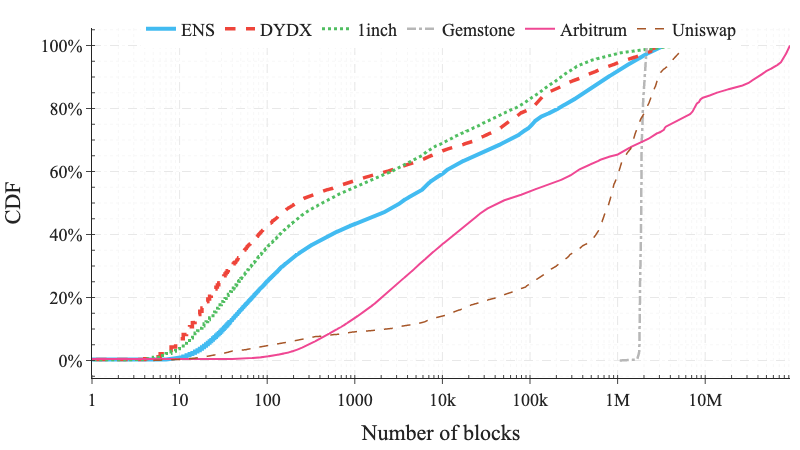

In [95]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    ecdf = ECDF(hops_blocks[protocol].hops)
    fig.add_trace(go.Scatter(x=ecdf.x, y=ecdf.y, name=plot_settings[protocol]['label'],
                             line=dict(color=plot_settings[protocol]['color'],
                             width=plot_settings[protocol]['width'],
                             dash=plot_settings[protocol]['style'])))

fig.update_layout(
    xaxis_title='Number of blocks',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.05, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
fig.write_image(plots_dir + 'number_of_blocks_until_exchange_log.pdf')
fig.show('png')

In [40]:
hops_time = {}
for protocol in tqdm(protocols):
    print(protocol)
    claimant_nodes = dfs[protocol]['claim']['receiver'].unique()
    claimant_time = dfs[protocol]['claim'][['receiver', 'timestamp']].set_index('receiver')[
        'timestamp'].to_dict()
    hops_time[protocol] = check_for_exchanges_time(graph=Gs[protocol], exchange_addresses=exchanges,
                                                   claimant_blocks=claimant_time, claimant_nodes=claimant_nodes)
    hops_time[protocol] = pd.DataFrame.from_dict(
        hops_time[protocol], orient='index', columns=['hops'])
    hops_time[protocol].sort_values(by='hops', ascending=True, inplace=True)

    hops_time[protocol].hops = hops_time[protocol].hops.dt.total_seconds() / \
        3600/24
    hops_time[protocol] = hops_time[protocol][hops_time[protocol]['hops'] >= 0]
    display(hops_time[protocol].hops.describe(
        percentiles=percentiles).to_frame().T)

  0%|          | 0/6 [00:00<?, ?it/s]

ens


count         mean          std  min          1%          5%  \
hops  38413.0  35.58895721  86.38436572  0.0  0.00167963  0.00311343   

             10%         20%         25%         50%          75%  \
hops  0.00480324  0.01034028  0.01530093  0.52224537  16.86635417   

              80%           90%           95%           99%           max  
hops  33.11975231  120.20064352  243.31757176  436.70718148  513.07488426

dydx


count         mean          std  min         1%          5%  \
hops  8216.0  25.66494854  76.65303973  0.0  0.0007772  0.00138889   

             10%         20%        25%         50%        75%          80%  \
hops  0.00194444  0.00337963  0.0044647  0.03310185  8.0463831  16.02592593   

              90%           95%           99%           max  
hops  62.97396991  171.60046296  380.02495139  568.07528935

1inch


count         mean          std  min          1%          5%  \
hops  23677.0  17.07506976  68.07735941  0.0  0.00082176  0.00165509   

             10%         20%         25%         50%         75%          80%  \
hops  0.00263889  0.00524306  0.00729167  0.06587963  4.19336806  10.03655787   

              90%          95%           99%           max  
hops  34.69125926  73.12024537  355.31065648  832.26902778

gemstone


count         mean         std          min           1%           5%  \
hops  20000.0  22.09570692  1.10575063  12.40592593  19.97705127  20.87862269   

              10%         20%          25%          50%          75%  \
hops  21.00541319  21.1764375  21.26958044  21.91159144  22.60116609   

              80%          90%          95%          99%          max  
hops  22.95688657  23.84534028  24.33811979  25.02117361  32.74844907

arbitrum


count         mean          std  min          1%          5%  \
hops  49656.0  28.29383653  66.48760841  0.0  0.00024306  0.00082176   

             10%         20%         25%         50%          75%  \
hops  0.00177083  0.00561343  0.00915509  0.11515046  11.88785012   

              80%           90%          95%           99%           max  
hops  21.70486111  118.58934028  227.4694184  274.01649769  283.20519676

uniswap


count          mean           std         min          1%          5%  \
hops  3906.0  183.17973615  203.85148515  0.00056713  0.00250116  0.01849826   

             10%         20%          25%          50%           75%  \
hops  0.34869792  6.43633102  16.70174769  122.3987963  268.56525174   

               80%          90%           95%           99%           max  
hops  329.96831019  450.9457581  650.58323495  869.19635243  931.11085648

In [96]:
fig = go.Figure(layout=get_plotly_layout(width=800, height=450))
for protocol in protocols:
    ecdf = ECDF(hops_time[protocol].hops)
    fig.add_trace(go.Scatter(x=ecdf.x, y=ecdf.y, name=plot_settings[protocol]['label'],
                             line=dict(color=plot_settings[protocol]['color'],
                             width=plot_settings[protocol]['width'],
                             dash=plot_settings[protocol]['style'])))

fig.update_layout(
    xaxis_title='Number of days',
    yaxis_title='CDF',
    legend=dict(xanchor='center', x=0.5, y=1.05, orientation='h'))

fig.update_xaxes(type='log')
fig.update_yaxes(tickformat=".0%")
fig.write_image(plots_dir + 'number_of_days_until_exchange_log.pdf')
fig.show()

In [97]:
for protocol in protocols:
    print(protocol, 100 *
          hops_time[protocol].query("hops <= 1").shape[0]/hops_time[protocol].shape[0])

ens 55.14539348658006
dydx 64.26484907497566
1inch 66.0852303923639
gemstone 0.0
arbitrum 60.339133236668275
uniswap 12.391193036354327


In [46]:
hops_time['1inch'].hops.sum()

404286.42672453704

In [47]:
for protocol in tqdm(protocols):
    exchange_addresses = [address for address in list(
        exchanges.keys()) if Gs[protocol].has_node(address)]
    print("{}: There are {} exchange addresses in the Graph".format(
        protocol, len(exchange_addresses)))

  0%|          | 0/6 [00:00<?, ?it/s]

ens: There are 88 exchange addresses in the Graph
dydx: There are 82 exchange addresses in the Graph
1inch: There are 124 exchange addresses in the Graph
gemstone: There are 1 exchange addresses in the Graph
arbitrum: There are 52 exchange addresses in the Graph
uniswap: There are 168 exchange addresses in the Graph


In [48]:
def precompute_hops(G, exchange_addresses):
    # Precompute shortest paths from all exchange addresses
    exchange_hops = {}
    for address in exchange_addresses:
        try:
            exchange_hops[address] = nx.single_source_shortest_path_length(
                G, source=address)
        except nx.NetworkXNoPath:
            exchange_hops[address] = {}
    return exchange_hops


def check_for_hops(precomputed_hops, source, exchange_addresses):
    # Find the minimum hop distance from source to any exchange address
    min_hops = float('inf')
    for address in exchange_addresses:
        if source in precomputed_hops.get(address, {}):
            min_hops = min(min_hops, precomputed_hops[address][source])
    return min_hops if min_hops != float('inf') else None

In [49]:
hops_protocols = {}

for protocol in tqdm(protocols):
    print(f"Processing protocol: {protocol}")
    claimant_nodes = dfs[protocol]['claim']['receiver'].unique()

    exchange_addresses = set(
        [address for address in exchanges.keys() if Gs[protocol].has_node(address)])
    print(
        f"There are {len(exchange_addresses)} exchange addresses in the Graph")

    # Precompute all shortest paths from exchange addresses. (Exchange -> Node).reverse() -----> Node -> Exchange
    precomputed_hops = precompute_hops(
        Gs[protocol].reverse(), exchange_addresses)

    hops_depth = {}
    for node in tqdm(claimant_nodes, desc=f'Processing nodes for {protocol}'):
        if node in exchange_addresses or not Gs[protocol].has_node(node):
            continue
        hops_depth[node] = check_for_hops(
            precomputed_hops, node, exchange_addresses)

    hops_protocols[protocol] = hops_depth

    # Save hops_depth with less frequent I/O
    with gzip.open(f"{data_dir}hops_{protocol}.pkl.gz", 'wb') as f:
        pickle.dump(hops_depth, f)

  0%|          | 0/6 [00:00<?, ?it/s]

Processing protocol: ens
There are 88 exchange addresses in the Graph


Processing nodes for ens:   0%|          | 0/102822 [00:00<?, ?it/s]

Processing protocol: dydx
There are 82 exchange addresses in the Graph


Processing nodes for dydx:   0%|          | 0/42682 [00:00<?, ?it/s]

Processing protocol: 1inch
There are 124 exchange addresses in the Graph


Processing nodes for 1inch:   0%|          | 0/43402 [00:00<?, ?it/s]

Processing protocol: gemstone
There are 1 exchange addresses in the Graph


Processing nodes for gemstone:   0%|          | 0/20014 [00:00<?, ?it/s]

Processing protocol: arbitrum
There are 52 exchange addresses in the Graph


Processing nodes for arbitrum:   0%|          | 0/583137 [00:00<?, ?it/s]

Processing protocol: uniswap
There are 168 exchange addresses in the Graph


Processing nodes for uniswap:   0%|          | 0/220220 [00:00<?, ?it/s]

In [64]:
# Distribution of hops for airdrop recipients connecting with exchanges
hops_dfs = {}
for protocol in hops_protocols:
    print(protocol)
    hops_dfs[protocol] = pd.DataFrame.from_dict(
        hops_protocols[protocol], orient='index')
    hops_dfs[protocol].columns = ['hops']
    display(hops_dfs[protocol].query('hops <= 1000000').hops.describe(
        percentiles=percentiles).to_frame().T)

ens


count        mean         std  min   1%   5%  10%  20%  25%  50%  75%  \
hops  86156.0  1.65409258  1.06360468  1.0  1.0  1.0  1.0  1.0  1.0  2.0  2.0   

      80%  90%  95%  99%   max  
hops  2.0  2.0  3.0  3.0  50.0

dydx


count        mean         std  min   1%   5%  10%  20%  25%  50%  75%  \
hops  40475.0  1.77106856  0.72732344  1.0  1.0  1.0  1.0  1.0  1.0  2.0  2.0   

      80%  90%  95%  99%   max  
hops  2.0  3.0  3.0  4.0  17.0

1inch


count        mean         std  min   1%   5%  10%  20%  25%  50%  75%  \
hops  41913.0  1.49466753  0.63068484  1.0  1.0  1.0  1.0  1.0  1.0  1.0  2.0   

      80%  90%  95%  99%  max  
hops  2.0  2.0  3.0  3.0  7.0

gemstone


count  mean  std  min   1%   5%  10%  20%  25%  50%  75%  80%  90%  \
hops  20000.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      95%  99%  max  
hops  1.0  1.0  1.0

arbitrum


count       mean         std  min   1%   5%  10%  20%  25%  50%  75%  \
hops  555036.0  2.3365007  0.78252345  1.0  1.0  1.0  2.0  2.0  2.0  2.0  3.0   

      80%  90%  95%  99%   max  
hops  3.0  3.0  3.0  4.0  31.0

uniswap


count        mean         std  min   1%   5%  10%  20%  25%  50%  \
hops  213066.0  2.21033389  0.66607268  1.0  1.0  2.0  2.0  2.0  2.0  2.0   

      75%  80%  90%  95%  99%   max  
hops  2.0  2.0  3.0  3.0  5.0  17.0

In [65]:
for protocol in dfs:
    print("The total amount claimed for {} is {}".format(
        protocol, dfs[protocol]['claim']['amount'].sum()))

The total amount claimed for ens is 19631848.51813893
The total amount claimed for dydx is 176966825.29149315
The total amount claimed for 1inch is 83238801.11042185
The total amount claimed for gemstone is 5.0394775e+16
The total amount claimed for arbitrum is 1092811500.0
The total amount claimed for uniswap is 136564980.488529


# Tokens sold at exchanges


In [84]:
def compute_account_balances(transfer_df, amount_column='amount'):
    balances_history_dict = dict()
    for _, row in tqdm(transfer_df.iterrows(), desc='Loading balances', total=transfer_df.shape[0]):
        if row['sender'] not in balances_history_dict:
            balances_history_dict[row['sender']] = {
                'current': 0, 'history': [], 'n_sender': 0, 'n_receiver': 0}
        if row['receiver'] not in balances_history_dict:
            balances_history_dict[row['receiver']] = {
                'current': 0, 'history': [], 'n_sender': 0, 'n_receiver': 0}

        balance = float(row[amount_column])
        balances_history_dict[row['sender']]['history'].append(
            {'block_number': row['block_number'], 'timestamp': row['timestamp'],
             'balance_before': balances_history_dict[row['sender']]['current'],
             'balance_after': balances_history_dict[row['sender']]['current']-balance})
        balances_history_dict[row['receiver']]['history'].append(
            {'block_number': row['block_number'], 'timestamp': row['timestamp'],
             'balance_before': balances_history_dict[row['receiver']]['current'],
             'balance_after': balances_history_dict[row['receiver']]['current']+balance})

        balances_history_dict[row['sender']]['n_sender'] += 1
        balances_history_dict[row['receiver']]['n_receiver'] += 1

        balances_history_dict[row['sender']]['current'] -= balance
        balances_history_dict[row['receiver']]['current'] += balance

    print("There are in total {} addresses".format(len(balances_history_dict)))
    return balances_history_dict

In [67]:
balances = dict()
for protocol in plot_settings:
    print(protocol)
    balances[protocol] = compute_account_balances(
        dfs[protocol]['transfer'], amount_column='amount')

ens


Loading balances:   0%|          | 0/711287 [00:00<?, ?it/s]

There are in total 197597 addresses
dydx


Loading balances:   0%|          | 0/482115 [00:00<?, ?it/s]

There are in total 114215 addresses
1inch


Loading balances:   0%|          | 0/1444316 [00:00<?, ?it/s]

There are in total 309497 addresses
gemstone


Loading balances:   0%|          | 0/261896 [00:00<?, ?it/s]

There are in total 20020 addresses
arbitrum


Loading balances:   0%|          | 0/28021747 [00:00<?, ?it/s]

There are in total 2042995 addresses
uniswap


Loading balances:   0%|          | 0/3982834 [00:00<?, ?it/s]

There are in total 1184525 addresses


In [68]:
exchange_balances = dict()
for protocol in tqdm(plot_settings, desc='Summing exchange balances'):
    balance = 0
    for exchange in exchanges:
        if exchange in balances[protocol]:
            balance += balances[protocol][exchange]['current']
    exchange_balances[protocol] = balance
for exchange_balance in exchange_balances:
    print("The exchange balance for {} is {}".format(
        exchange_balance, exchange_balances[exchange_balance]))

Summing exchange balances:   0%|          | 0/6 [00:00<?, ?it/s]

The exchange balance for ens is 8291775.181794645
The exchange balance for dydx is 76603684.03018776
The exchange balance for 1inch is 279210814.6316162
The exchange balance for gemstone is 291997156478790.7
The exchange balance for arbitrum is 365496416.43809885
The exchange balance for uniswap is 39547376.12859592


In [ ]:
for protocol in protocols:
    print(protocol, 100 *
          exchange_balances[protocol]/dfs[protocol]['claim']['amount'].sum())

ens 42.236344550710164
dydx 43.28703072115863
1inch 335.43348883800513
gemstone 0.5794195062460159
arbitrum 33.44551337884885
uniswap 28.958651029806113


In [85]:
exchange_balances

{'ens': 8291775.181794645,
 'dydx': 76603684.03018776,
 '1inch': 279210814.6316162,
 'gemstone': 291997156478790.7,
 'arbitrum': 365496416.43809885,
 'uniswap': 39547376.12859592}

In [69]:
exhance_nodes = dict()
for protocol in plot_settings:
    exhance_nodes[protocol] = list()
    for node in subgraphs[protocol].nodes():
        if node in exchanges:
            exhance_nodes[protocol].append(node)
    print(protocol, len(exhance_nodes[protocol]))

ens 20
dydx 29
1inch 27
gemstone 1
arbitrum 22
uniswap 87


In [70]:
# subgraphs['ens'].has_node('0xb9c4a5522a2f8ba9e2ff7063df8c02ed443337a3')
# subgraphs['ens']['0xb9c4a5522a2f8ba9e2ff7063df8c02ed443337a3']

In [72]:
# balances = dict()
# for protocol in plot_settings:
#     print(protocol)
#     balances[protocol] = compute_account_balances(
#         dfs[protocol]['transfer'], amount_column='amount')

In [73]:
balances = dict()
for protocol in tqdm(plot_settings):
    amount = 0
    for node in exchanges:
        edges = subgraphs[protocol].in_edges(node, data=True)
        amount += sum([float(edge[2]['amount']) for edge in edges])
    balances[protocol] = amount
balances

  0%|          | 0/6 [00:00<?, ?it/s]

{'ens': 38774640.25678487,
 'dydx': 506399011.93375266,
 '1inch': 737798984.474915,
 'gemstone': 1.9144513323931466e+17,
 'arbitrum': 1051981091.681134,
 'uniswap': 883379210.9883149}

In [75]:
exchanges_df = pd.read_csv(data_dir+'addresses-labels.csv')
exchanges_df.head()

address  \
0  0x8315177ab297ba92a06054ce80a67ed4dbd7ed3a   
1  0xa02573c4ad15c16b48f10842aac9c9ea405b65a3   
2  0xa7883e0060286b7b9e3a87d8ef9f180a7c2673ce   
3  0xf70da97812cb96acdf810712aa562db8dfa3dbef   
4  0xb49c4e680174e331cb0a7ff3ab58afc9738d5f8b   

                                  label category  
0                              Arbitrum  bridges  
1  Bridge LayerZero Multichain Power XL  bridges  
2                Bridge Orbiter Finance  bridges  
3     Bridge Relay Protocol: EOA Bridge  bridges  
4                       Bridge Stargate  bridges

In [76]:
new_exchange_dict = exchanges_df[['address', 'label']].set_index('address')[
    'label'].to_dict()
new_exchange_dict['0xb38e8c17e38363af6ebdcb3dae12e0243582891d'] = 'Binance'
new_exchange_dict['0x10417734001162ea139e8b044dfe28dbb8b28ad0'] = 'Rhino.fi: Bridge'

new_exchange_dict['0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45'] = 'Uniswap - SwapRouter02'

In [78]:
dfs['uniswap']['claim']['amount'].sum()

136564980.488529

In [79]:
dfs['arbitrum']['claim']['amount'].sum()

1092811500.0

In [81]:
for address in dfs['arbitrum']['claim'][['receiver', 'amount']].sort_values(by='amount', ascending=False).head(20)['receiver'].values:
    if address not in exchange_addresses:
        print(address)

0x8592c855f55e9c233581ac7411a1db4efa08ad03
0x0a04c869d4d48e3d4659260bf61ceb8df95dfaa3
0x8e2bde4c1b7f117270dccf394c32653a32708898
0x4b0322e23d4de507fcbf591a5297ec11cfd7e98c
0xe78de40a5113f5961253d6419885746e58b904ca
0x9128d7a95b7811af2da2ced9116b04c78792b84f
0xa8e32be4ca13b271673f8b01f1eeacfde66fa413
0xdc8c1959c74ab2cb3819add153e62739d12be550
0x9f2070efa98cc424012fe182c2c6cc0aff8d12db
0xce86508928ec67fc1c21426810b24c3906a70cac
0x7a1bcb582fbdfb6fae842905eabaed6c1992b349
0x7aa1349fe07826f3f6c9238f75dce46f4d8bd33c
0x5f8fd99047265af45071f40042da15c1bd375b85
0xce61705386179efa662b6f8a2d805eacde533834
0x328739e4901cd242072353ec377d72fb87eca876
0xdbd296c51b1d32f5d8cc58cd6f8a5f70e6d92d33
0xba10031f3b6f5f49797e300a765f2f5d89ec0fbf
0x48a5a6a01ba89cddf97d2d552923d5a11401ed19
0x37ce6773eb3dc887864afe5698d5e57d35d8ba3b
0x1f0b4a37dd271b43055c867c473bcc12d504c162


In [82]:
# General airdrop distribution statistics
for protocol in protocols:
    claimant = dfs[protocol]['claim']['receiver'].unique()
    data = dfs[protocol]['transfer'][((dfs[protocol]['transfer']['sender'].isin(
        claimant)) & (dfs[protocol]['transfer']['receiver'].isin(exchanges)
                      | dfs[protocol]['transfer']['receiver'].isin(new_exchange_dict)))]
    data = data.reset_index().sort_values(
        by=['block_number', 'transaction_index', 'log_index'])
    visited = set()
    balance = 0
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        if row['sender'] not in visited:
            balance += float(row['amount'])
            visited.add(row['sender'])
    print(protocol, 100*balance/dfs[protocol]['claim']['amount'].sum(),
          balance, dfs[protocol]['claim']['amount'].sum())

  0%|          | 0/59921 [00:00<?, ?it/s]

ens 36.6238039309809 7189929.709310382 19631848.51813893


  0%|          | 0/35345 [00:00<?, ?it/s]

dydx 35.44780894675316 62730862.12846295 176966825.29149315


  0%|          | 0/50047 [00:00<?, ?it/s]

1inch 54.05471904150862 44994500.07375869 83238801.11042185


  0%|          | 0/80037 [00:00<?, ?it/s]

gemstone 95.01164803054768 4.788090624878643e+16 5.0394775e+16


  0%|          | 0/99214 [00:00<?, ?it/s]

arbitrum 10.14968514715237 110916926.50187302 1092811500.0


  0%|          | 0/12746 [00:00<?, ?it/s]

uniswap 5.499764854012487 7510752.799797128 136564980.488529


In [ ]:
# Sybil attacks
# - Gemstone:
# Section before 3 where we describe how does sybil attacks look like
# - Here is one case where all transfers had one hop to the exchange describe it in details and use Gemstone as a study case


# Move section 5 and 6 probably moving to the appendix
# - split thable 4